In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pytensor as pt
import statistics as stats
from pymc.ode import DifferentialEquation
from scipy.integrate import odeint

In [2]:
DT = 1

my_num = 0

L = .5 

R = 0.013 

A = (5*L**2)/(108*(R**2/5 + L**2/54)) 

In [3]:
import scipy.io as io

data_gsc = io.loadmat("data/Cell_timealigned_data.mat")
ani_gsc = np.flip(data_gsc["ani_cell_mean"].flatten())
ani_gsc_SE = np.flip(data_gsc["ani_cell_SE"].flatten() )
nmy_gsc = np.flip(data_gsc["nmy_cell_mean"].flatten())
nmy_gsc_SE = np.flip(data_gsc["nmy_cell_SE"].flatten() )
circumference_gsc = np.flip(data_gsc["c_mean"].flatten() ) 
circumference_gsc_SE = np.flip(data_gsc["c_SE"].flatten() ) 

In [4]:
trace_apop_ani = list
trace_apop_nmy = list 
trace_gsc_ani = list 
trace_gsc_nmy = list 
trace_cell_ani = list 
trace_cell_nmy = list 


In [5]:
def ringclose(r, t, p): 
    W = p[0]*nmy_gsc[0]*p[1]*ani_gsc[0]
    W2 = r[0]*p[4]*p[2]*p[3]*(W/(p[1]*ani_gsc[0] + p[2]*nmy_gsc[0])**2)
    return W2

times = DT*np.arange(0, len(ani_gsc),1)

x = np.matrix(circumference_gsc)
circumference_gsc1 = np.array(x.T)

x = np.matrix(circumference_gsc_SE) 
circumference_gsc_SE1 = np.array(x.T)

In [6]:
ode_model = DifferentialEquation(func = ringclose, times = times, n_states = 1, n_theta = 5, t0=0)
gammax = 1
gammam = 1 
constrained_prior_vp = pm.find_constrained_prior(pm.Gamma,lower= 0.0001, upper = 9, mass = .95, init_guess = dict(alpha=1,beta=1))

with pm.Model() as model:
    
    alpha = pm.Normal('alpha',mu = 0, sigma = 1)
    #gammam = pm.Normal('gammam', mu = 0, sigma = 1) 
    #gammax = pm.Normal('gammax', mu = 0, sigma = 1) 
    v_p = pm.Gamma('v_p',**constrained_prior_vp)
    #sigma = pm.HalfCauchy("sigma", 1)
    sigma = circumference_gsc_SE1
    ode_solution = ode_model(y0 =circumference_gsc1[0], theta=[alpha, gammax, gammam, v_p, A])
    
    Y = pm.Normal("Y", mu= ode_solution, sigma = sigma, observed = circumference_gsc1)
    
    prior = pm.sample_prior_predictive(10) 
    trace = pm.sample(2000, tune = 1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace) 
    

Sampling: [Y, alpha, v_p]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, v_p]


Output()

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1648 seconds.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Y]


Output()

array([[<Axes: >, None],
       [<Axes: xlabel='v_p', ylabel='alpha'>, <Axes: >]], dtype=object)

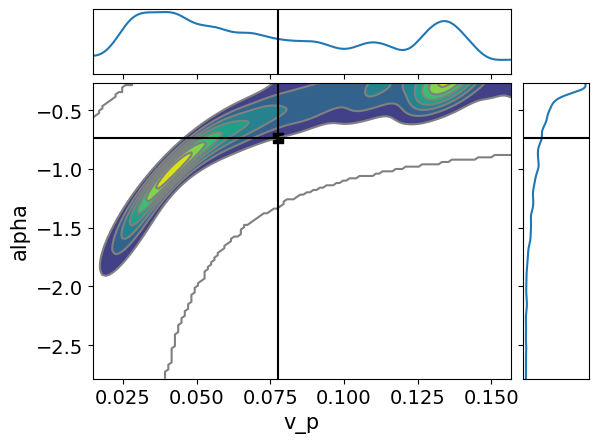

In [7]:
az.plot_pair(trace, var_names = [ 'v_p','alpha'], kind = 'kde', marginals = 'True', point_estimate = 'mean')

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'v_p'}>, <Axes: title={'center': 'v_p'}>]],
      dtype=object)

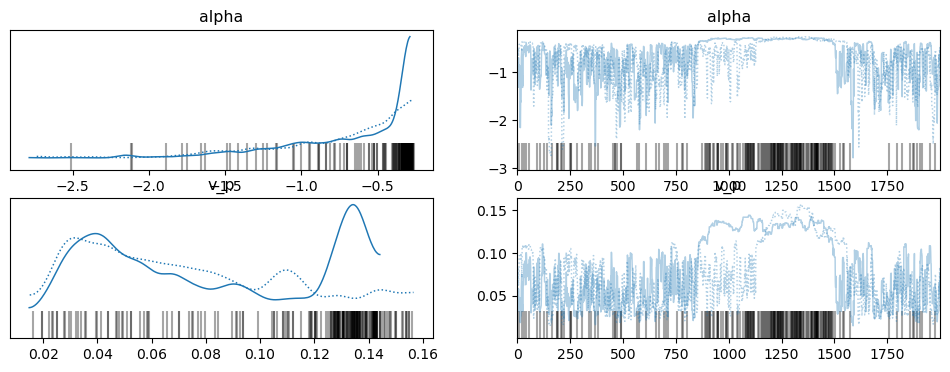

In [8]:
az.plot_trace(trace)

In [9]:
trace.unstack(inplace = "True")
a= az.extract(trace, group = 'posterior', var_names = ['alpha'], keep_dataset = 'true')
alpha = a.alpha.values


a= az.extract(trace, group = 'posterior', var_names = ['v_p'], keep_dataset = 'true')
v_p = a.v_p.values

active_stress = -((4*np.pi*R**3)/27)*(L**2)/12 * gammam.mean()*v_p.mean()*nmy_gsc**2 * (-alpha.mean()*ani_gsc*gammam.mean()*nmy_gsc)/(gammax.mean()*ani_gsc + gammam.mean()*nmy_gsc)

viscosity = ((4*np.pi*R**3)/(15))*nmy_gsc**2 * (gammax.mean()*ani_gsc + gammam.mean()*nmy_gsc)*((R**2)/5 + L**2/54) 

alpha.mean()

AttributeError: 'int' object has no attribute 'mean'

In [ ]:
ani_rho = ani_gsc
nmy_rho = nmy_gsc
plt.plot(viscosity, active_stress) 

In [ ]:
mcmc_prediction = odeint(ringclose, t=times, y0 = circumference_gsc1[0], args = tuple([[alpha.mean(), gammax.mean(), gammam.mean(), v_p.mean(), A]]))

In [ ]:
plt.plot(mcmc_prediction)
plt.plot(circumference_gsc)

In [10]:
io.savemat('CELL_VPA_A.mat', dict(alpha = alpha))


In [11]:
io.savemat('CELL_VPA_VP.mat', dict(v_p = v_p))